In [146]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs
import matplotlib.pyplot as plt
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [147]:
x_1 = np.linspace(-1,1,256)
x_2 = np.linspace(1,-1,256)
x_3 = np.linspace(-1,1,256)

X, Y, Z = np.meshgrid(x_1,x_2,x_3)

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [148]:
X_v_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None],Z.flatten(order='F')[:,None]))

lb = np.array([-1, -1, -1]) #lower bound
ub = np.array([1, 1, 1])  #upper bound

usol = 1/(4 * np.pi*np.sqrt(X**2 + Y**2 + Z**2))+np.sin(X * Y + Z)
vsol = np.sin(X * Y + Z)
3
v_true = vsol.flatten('F')[:,None] 

# Training Data

In [149]:
def trainingdata(N_v,N_f):
    
    leftedge_x = np.hstack((X[0,:].flatten('a')[:,None], Y[0,:].flatten('a')[:,None], Z[0,:].flatten('a')[:,None]))
    leftedge_v = vsol[0,:].flatten('a')[:,None]
    
    rightedge_x = np.hstack((X[-1,:].flatten('a')[:,None], Y[-1,:].flatten('a')[:,None], Z[-1,:].flatten('a')[:,None]))
    rightedge_v = vsol[-1,:].flatten('a')[:,None]
    
    backedge_x = np.hstack((X[:,0].flatten('a')[:,None], Y[:,0].flatten('a')[:,None], Z[:,0].flatten('a')[:,None]))
    backedge_v = vsol[:,0].flatten('a')[:,None]
    
    frontedge_x = np.hstack((X[:,-1].flatten('a')[:,None], Y[:,-1].flatten('a')[:,None], Z[:,-1].flatten('a')[:,None]))
    frontedge_v = vsol[:,-1].flatten('a')[:,None]
    
    bottomedge_x = np.hstack((X[:,:,0].flatten('a')[:,None], Y[:,:,0].flatten('a')[:,None], Z[:,:,0].flatten('a')[:,None]))
    bottomedge_v = vsol[:,:,0].flatten('a')[:,None]
    
    topedge_x = np.hstack((X[:,:,-1].flatten('a')[:,None], Y[:,:,-1].flatten('a')[:,None], Z[:,:,-1].flatten('a')[:,None]))
    topedge_v = vsol[:,:,-1].flatten('a')[:,None]
    
    all_X_v_train = np.vstack([leftedge_x, rightedge_x, backedge_x, frontedge_x, bottomedge_x, topedge_x])
    all_v_train = np.vstack([leftedge_v, rightedge_v, backedge_v, frontedge_v, bottomedge_v, topedge_v])
     
    #choose random N_v points for training
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False) 
    
    X_v_train = all_X_v_train[idx[0:N_v], :] #choose indices from  set 'idx' (x,t)
    v_train = all_v_train[idx[0:N_v],:]      #choose corresponding v
    
    '''Collocation Points'''

    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(3,N_f)
    X_f_train = np.vstack((X_f, X_v_train)) # append training points to collocation points 
    
    return X_f_train, X_v_train, v_train 

# SSDRM

Creating sequential layers using the class
tf.Module

In [150]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_v = self.loss_function(self.forward(x), y)
                
        return loss_v
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
        x_3_f = x_to_train_f[:,[2]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        v = self.forward(g)
                
        v_x = autograd.grad(v,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                                            
        v_x_1 = v_x[:,[0]]
        
        v_x_2 = v_x[:,[1]]
        
        v_x_3 = v_x[:,[2]]
                        
        k = x_1_f**2 + x_2_f**2 + x_3_f**2 + 1
        F = (x_1_f**2 + x_2_f**2 + x_3_f**2 + 1)*(x_1_f**2 + x_2_f**2 +1)*np.sin(x_1_f*x_2_f+x_3_f)-(4*x_1_f*x_2_f+2*x_3_f)*np.cos(x_1_f*x_2_f+x_3_f)
        
        f = 1/2 * k * (v_x_1**2 + v_x_2**2 + v_x_3**2) - F * v

        loss_f = torch.mean(f)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f,sigma):

        loss_v = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)

        loss = sigma/2 * loss_v + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_v_train, v_train, X_f_train, sigma)
        
        # error_vec, _ = SSDRM.test()
        
        global ite, iteration_vec, fun_vec
        ite = ite + 1
        
        if (ite % 100 == 0):
            iteration_vec.append(ite)
            fun_vec.append(loss_val.item())
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred = self.forward(X_v_test_tensor)
        
        error_vec = torch.linalg.norm((v-v_pred),2)/torch.linalg.norm(v,2)        # Relative L2 Norm of the error (Vector)
        
        v_pred = np.reshape(v_pred.cpu().detach().numpy(),(256,256,256),order='F') 
        
        return error_vec, v_pred

# Loss Function

The loss function consists of two parts:

    loss_BC: MSE error of boundary losses
    loss_PDE: variational functional for the PDE


In [151]:
N_v = 400 
N_f = 10000 

X_f_train_np_array, X_v_train_np_array, v_train_np_array = trainingdata(N_v,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
v_train = torch.from_numpy(v_train_np_array).float().to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
v = torch.from_numpy(v_true).float().to(device)

iteration_vec = []
fun_vec = []

layers = np.array([3, 3, 3, 1])

SSDRM = Sequentialmodel(layers)
       
SSDRM.to(device)

'Neural Network Summary'

print(SSDRM)
params = list(SSDRM.parameters())

rho = 1.5
sigma = 1153.3
start_time = time.time()
    
ite = 0
optimizer = torch.optim.LBFGS(SSDRM.parameters(), lr=0.01, 
                              max_iter = 20000, 
                              max_eval = None, 
                              tolerance_grad = 1e-06, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
optimizer.step(SSDRM.closure)

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

error_vec, _ = SSDRM.test()

''' Model Accuracy ''' 
error_vec, v_pred = SSDRM.test()

print('sigma: %f' %(sigma))
print('Test Error: %.5f'  % (error_vec))

u_pred = 1/(4 * np.pi*np.sqrt(X**2 + Y**2 + Z**2)) + v_pred

print(iteration_vec,fun_vec)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=3, bias=True)
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)
Training time: 11.83
sigma: 1153.300000
Test Error: 0.02640
[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800] [11.394957542419434, 6.3040924072265625, 3.2527449131011963, 2.788896083831787, 2.685448408126831, 2.5917701721191406, 2.5139060020446777, 2.2717318534851074, 1.9297215938568115, 1.7323002815246582, 1.2424659729003906, 1.0814123153686523, 0.7423074245452881, 0.5383932590484619, 0.4985194802284241, 0.4841644763946533, 0.46326541900634766, 0.46064114570617676]


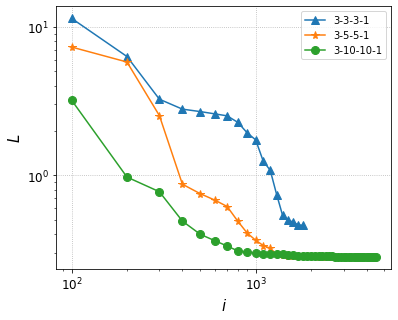

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import matplotlib.ticker

interation_vec1=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800]
fun_vec1=[11.394957542419434, 6.3040924072265625, 3.2527449131011963, 2.788896083831787, 2.685448408126831, 2.5917701721191406, 2.5139060020446777, 2.2717318534851074, 1.9297215938568115, 1.7323002815246582, 1.2424659729003906, 1.0814123153686523, 0.7423074245452881, 0.5383932590484619, 0.4985194802284241, 0.4841644763946533, 0.46326541900634766, 0.46064114570617676]
interation_vec2=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800]
fun_vec2=[7.303863048553467, 5.790124416351318, 2.5224571228027344, 0.8709726333618164, 0.7518970370292664, 0.6808887124061584, 0.6165092587471008, 0.49063658714294434, 0.40797916054725647, 0.36546629667282104, 0.336626261472702, 0.3229120373725891, 0.2934948801994324, 0.28912967443466187, 0.2870725095272064, 0.28627416491508484, 0.2857796251773834, 0.2854216992855072, 0.28493532538414, 0.28455501794815063, 0.284360408782959, 0.28386780619621277, 0.2834601104259491, 0.2827467918395996, 0.28207170963287354, 0.28184494376182556, 0.28156134486198425, 0.2814566195011139]
interation_vec3=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500]
fun_vec3=[3.207050323486328, 0.9728529453277588, 0.775152325630188, 0.49164602160453796, 0.40070414543151855, 0.36294078826904297, 0.3341312110424042, 0.3097011148929596, 0.3051183521747589, 0.3000088930130005, 0.2961420714855194, 0.2951376438140869, 0.29451408982276917, 0.29340600967407227, 0.2912599742412567, 0.28965795040130615, 0.2883666455745697, 0.2877330780029297, 0.287352979183197, 0.28685256838798523, 0.2859532833099365, 0.28556957840919495, 0.28527796268463135, 0.284991055727005, 0.28466522693634033, 0.28410205245018005, 0.28377285599708557, 0.2835029363632202, 0.2833329141139984, 0.2830098569393158, 0.28282514214515686, 0.28258877992630005, 0.28242775797843933, 0.2823086977005005, 0.28217774629592896, 0.28203344345092773, 0.28187471628189087, 0.2816755473613739, 0.28150102496147156, 0.28129419684410095, 0.28118616342544556, 0.28105050325393677, 0.2809146046638489, 0.28086480498313904, 0.2807520925998688]

fig_4 = plt.figure(4, figsize=(6, 5))
plt.xlabel('$i$',size=15)
plt.ylabel('$L$',size=15)
plt.tick_params(labelsize=12)
#y_major_locator=MultipleLocator(0.04)
#ax=plt.gca()
#ax.yaxis.set_major_locator(y_major_locator)
plt.loglog(interation_vec1,fun_vec1,marker='^',markersize=8,label='3-3-3-1')
plt.loglog(interation_vec2,fun_vec2,marker='*',markersize=8,label='3-5-5-1')
plt.loglog(interation_vec3,fun_vec3,marker='o',markersize=8,label='3-10-10-1')
plt.grid(linestyle=":")
plt.subplots_adjust(bottom=0.15)
plt.legend()
plt.savefig('lossfunction3.3.png',bbox_inches='tight')
plt.show()